In [1]:
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor,
)
import matplotlib.pyplot as plt
from src.models.utils.data import FoodPricingDataset, FoodPricingLazyDataset
import torch
from itertools import islice

In [2]:
img_transform = Compose(
    [
        Resize(size=(224, 224)),
        ToTensor(),
        # Normalize(
        #     mean=[0.485, 0.456, 0.406],
        #     std=[0.229, 0.224, 0.225],
        # )
    ]
)

In [3]:
training_data = FoodPricingDataset(
    img_transform=img_transform, txt_transform=lambda x: x, split="train"
)

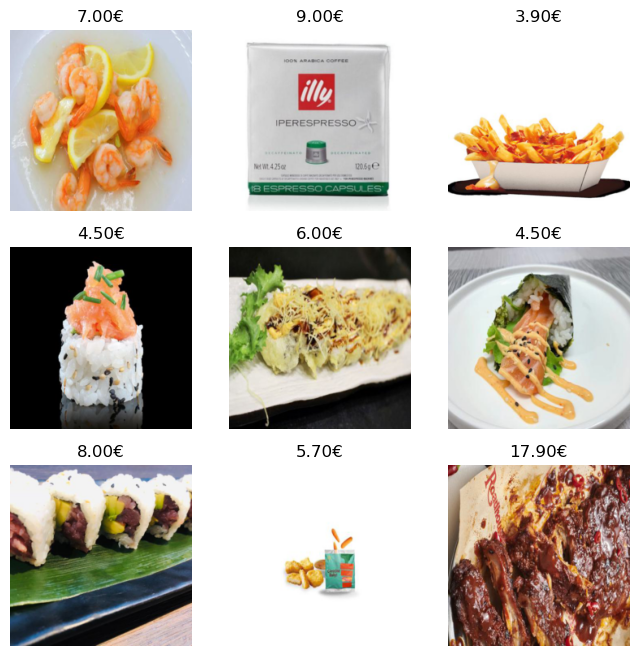

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{sample['label'].numpy()[0] / 100:,.2f}€")
    plt.axis("off")
    plt.imshow(sample["img"].permute(1, 2, 0))
plt.show()

In [5]:
for i in islice(training_data.iter_txt(), 5):
    print(i)

Menù Burgers Panino, patatine e bevanda inclusi
Baby Crest Cotoletta di pollo 100g ,cheddar ,maionese.
!!!New!!! New York City (Veggie) Beyond meat, doppio cheddar, cipolle rosse grigliate, misticanza, pomodori, salsa thousand island.
!!! New!!! Live Green (Vegan) Beyond meat, cipolle rosse grigliate, verdure grigliate, cavolo cappuccio, maionese vegana.
Lovely Burger di verdure verdi (cavolo riccio, broccoli, spinaci, scalogni, fiocchi d'avena, frumento), cipolle rosse grigliate, verdure grigliate, insalata, pomodori, maionese


In [6]:
%%timeit -n 1 -r 5

for idx in range(len(training_data)):
    training_data.alternative_getitem__(idx)

19.1 s ± 152 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [7]:
%%timeit -n 1 -r 5

for idx in range(len(training_data)):
    training_data[idx]

18.4 s ± 196 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


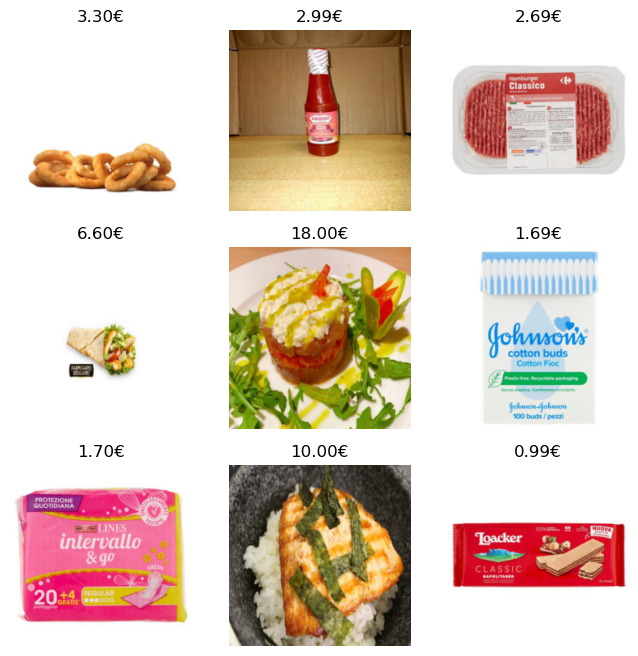

In [8]:
lazy_training_data = FoodPricingLazyDataset(
    img_transform=img_transform, txt_transform=lambda x: x, split="train"
)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{sample['label'].numpy()[0] / 100:,.2f}€")
    plt.axis("off")
    plt.imshow(sample["img"].permute(1, 2, 0))
plt.show()

In [9]:
for i in islice(lazy_training_data.iter_txt(), 5):
    print(i)

Menù Burgers Panino, patatine e bevanda inclusi
Baby Crest Cotoletta di pollo 100g ,cheddar ,maionese.
!!!New!!! New York City (Veggie) Beyond meat, doppio cheddar, cipolle rosse grigliate, misticanza, pomodori, salsa thousand island.
!!! New!!! Live Green (Vegan) Beyond meat, cipolle rosse grigliate, verdure grigliate, cavolo cappuccio, maionese vegana.
Lovely Burger di verdure verdi (cavolo riccio, broccoli, spinaci, scalogni, fiocchi d'avena, frumento), cipolle rosse grigliate, verdure grigliate, insalata, pomodori, maionese


In [10]:
%%timeit -n 1 -r 5

for idx in range(len(lazy_training_data)):
    lazy_training_data[idx]

1min 24s ± 2.94 s per loop (mean ± std. dev. of 5 runs, 1 loop each)
